This kernel is inspired by [Vicen's excellent idea](https://www.kaggle.com/vicensgaitan/salt-jigsaw-puzzle) of organizing train & test images in connected puzzles. You can find his original R Kernel [here](https://www.kaggle.com/vicensgaitan/salt-jigsaw-puzzle). In this kernel i use KD Trees to find the nearest images and combine them. You can try experimenting with different threshold values and different distance metric to get different combination of images.

# Loading Libraries

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm_notebook
import os
from keras.preprocessing.image import load_img
from sklearn.preprocessing import StandardScaler
import gc
import matplotlib.pyplot as plt
from sklearn.neighbors import KDTree 
%matplotlib inline

# loading train and test data

In [ ]:
train_img_path = '../input/train/images/'
train_mask_path = '../input/train/masks/'
test_path = '../input/test/images/'
train_files = np.array(os.listdir(train_img_path))
test_files = np.array(os.listdir(test_path))
all_files = np.append(train_files,test_files,axis=0)

In [ ]:
img_train = np.zeros((4000,101,101))
mask_train = np.zeros((4000,101,101))
for i,file in tqdm_notebook(enumerate(train_files)):
    img_train[i] = np.expand_dims(np.array(load_img(train_img_path+file))[:,:,0],axis=0)
    mask_train[i] = np.expand_dims(np.array(load_img(train_mask_path+file))[:,:,0],axis=0)
    
img_test = np.zeros((18000,101,101))
for i,file in tqdm_notebook(enumerate(test_files)):
    img_test[i] = np.expand_dims(np.array(load_img(test_path+file))[:,:,0],axis=0)

In [ ]:
all_arr = np.append(img_train,img_test,axis=0)
all_arr_orig = np.append(img_train,img_test,axis=0)
all_arr = (all_arr - all_arr.mean()) / all_arr.std()
del img_train,img_test
gc.collect()

# scaling and getting edges

In [ ]:
all_u_ex = 2*all_arr[:,0,:] - all_arr[:,1,:]
all_u_ex = (all_u_ex - all_u_ex.mean()) / all_u_ex.std()

all_d_ex = 2*all_arr[:,100,:]-all_arr[:,99,:]
all_d_ex = (all_d_ex - all_d_ex.mean()) / all_d_ex.std()

all_l_ex=  2*all_arr[:,:,0]-all_arr[:,:,1]
all_l_ex = (all_l_ex - all_l_ex.mean()) / all_l_ex.std()

all_r_ex=  2*all_arr[:,:,100]-all_arr[:,:,99]
all_r_ex = (all_r_ex - all_r_ex.mean()) / all_r_ex.std()

# function for combining the images

In [ ]:
def gen_comb_img(all_arr_orig,good_idx_ar,ind,pos='du'):
    combined_img_ar = None
    img_idx = []; match_img_idx = []
    for val in range(len(good_idx_ar)):
        good_idx = good_idx_ar[val]
        if np.std(all_arr_orig[ind[good_idx,0]])==0: continue            
        if pos=='du':  #down-up
            combined_img = np.append(all_arr_orig[ind[good_idx,0]],all_arr_orig[good_idx],axis=0)
        elif pos=='ud':  #up-down
            combined_img = np.append(all_arr_orig[good_idx],all_arr_orig[ind[good_idx,0]],axis=0)
        elif pos=='lr':
            combined_img = np.append(all_arr_orig[good_idx],all_arr_orig[ind[good_idx,0]],axis=1)
        elif pos=='rl':
            combined_img = np.append(all_arr_orig[ind[good_idx,0]],all_arr_orig[good_idx],axis=1)
        else:
            print('Wrong Argument Value for Position')
            return
        img_idx.append(good_idx);match_img_idx.append(ind[good_idx,0])
        combined_img = np.expand_dims(combined_img,axis=0)
        if combined_img_ar is None: 
            combined_img_ar = combined_img
        else:
            combined_img_ar = np.append(combined_img_ar,combined_img,axis=0)          
    return combined_img_ar,all_files[img_idx],all_files[match_img_idx]

# up-down

In [ ]:
tree = KDTree(all_u_ex)
dist_ud, ind_ud = tree.query(all_d_ex, k=2) 

In [ ]:
thresh = 0.4 #increase threshold to find more images
print(np.sum(dist_ud[:,0] < thresh))
good_idx_ud = np.ravel(np.where(dist_ud[:,0]<thresh))
combined_img_ud,img_id,match_id = gen_comb_img(all_arr_orig,good_idx_ud,ind_ud,pos='ud')

In [ ]:
for j in range(3):
    plt.figure(figsize=(15,15))
    for i in range(8):
        plt.subplot(1,8,i+1)
        plt.imshow(combined_img_ud[j*3+i],cmap='binary')
#         plt.text(0, 0,img_id[j*3+i][:-4]+' '+match_id[j*3+i][:-4],fontsize=8)
        plt.axis('off')
    plt.tight_layout()

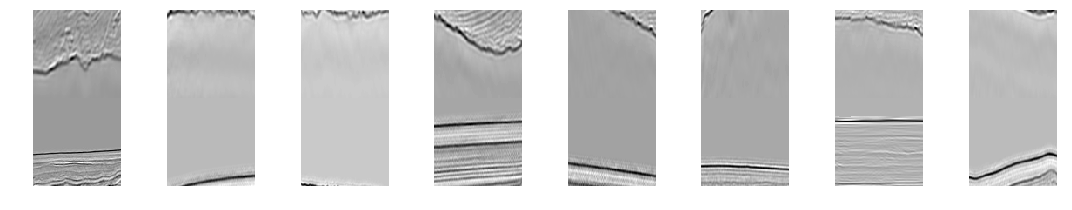

# down-up

In [ ]:
tree = KDTree(all_d_ex)
dist_du, ind_du = tree.query(all_u_ex, k=2) 

In [ ]:
thresh = 0.4 #increase threshold to find more images
print(np.sum(dist_du[:,0] < thresh))
good_idx_du = np.ravel(np.where(dist_du[:,0]<thresh))
combined_img_du,img_id,match_id = gen_comb_img(all_arr_orig,good_idx_du,ind_du,pos='du')

In [ ]:
for j in range(3):
    plt.figure(figsize=(15,15))
    for i in range(8):
        plt.subplot(1,8,i+1)
        plt.imshow(combined_img_du[j*3+i],cmap='binary')
#         plt.text(0, 0,img_id[j*3+i][:-4]+' '+match_id[j*3+i][:-4],fontsize=8)
        plt.axis('off')
    plt.tight_layout()

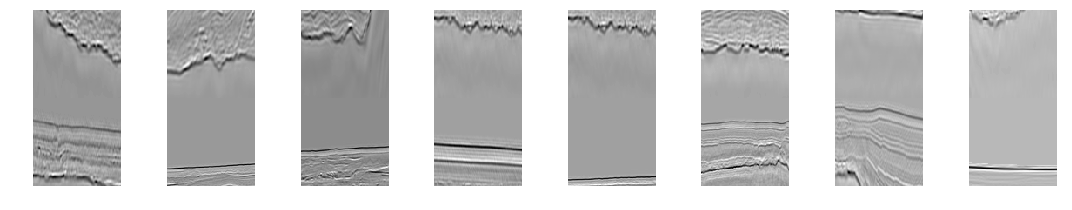

# left-right

In [ ]:
tree = KDTree(all_l_ex)
dist_lr, ind_lr = tree.query(all_r_ex, k=2) 

In [ ]:
thresh = 0.65
print('No.of pairs',np.sum(dist_lr[:,0] < thresh))
good_idx_lr = np.ravel(np.where(dist_lr[:,0]<thresh))
combined_img_lr,img_id,match_id = gen_comb_img(all_arr_orig,good_idx_lr,ind_lr,pos='lr')

In [ ]:
for j in range(5):
    plt.figure(figsize=(15,30))
    for i in range(5):
        plt.subplot(1,5,i+1)
        plt.imshow(combined_img_lr[j*5+i],cmap='binary')
#         plt.text(0, 0,img_id[j*3+i][:-4]+' '+match_id[j*3+i][:-4],fontsize=14)
        plt.axis('off')
    plt.tight_layout()

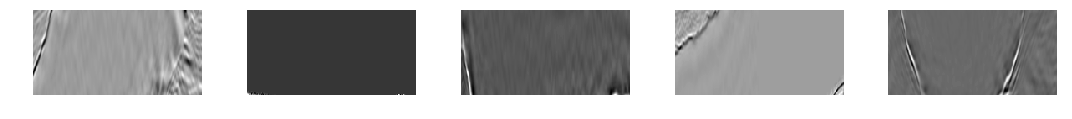

# right - Left

In [ ]:
tree = KDTree(all_r_ex)
dist_rl, ind_rl = tree.query(all_l_ex, k=2) 

In [ ]:
thresh = 0.4
print('No.of pairs',np.sum(dist_rl[:,0] < thresh))
good_idx_rl = np.ravel(np.where(dist_rl[:,0]<thresh))
combined_img_rl,img_id,match_id = gen_comb_img(all_arr_orig,good_idx_rl,ind_rl,pos='rl')

In [ ]:
for j in range(5):
    plt.figure(figsize=(15,30))
    for i in range(5):
        plt.subplot(1,5,i+1)
        plt.imshow(combined_img_rl[j*5+i],cmap='binary')
#         plt.text(0, 0,img_id[j*3+i][:-4]+' '+match_id[j*3+i][:-4],fontsize=14)
        plt.axis('off')
    plt.tight_layout()

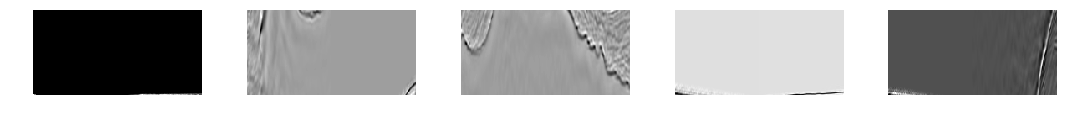

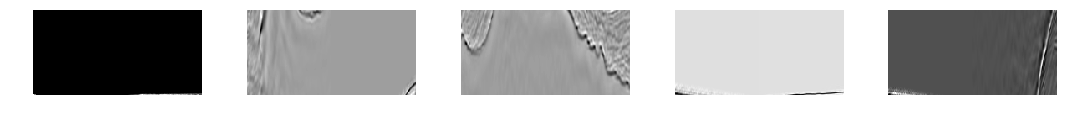